In [1]:
%pip install -U jax
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

print("JAX version:", jax.__version__)

# DO NOT MODIFY THE CONTENTS OF THIS CELL

# Simulation parameters
num_steps=200 # total number of simulation steps
dt=0.05 # time step size
g=9.8 # gravity acceleration constant
bounce=0.8 # bounce energy retention factor

def step(state):
    """
    One physics step for a bouncing ball.
    Args:
        state: jnp.array([x, y, vx, vy])
    Returns:
        new_state: jnp.array([x_new, y_new, vx_new, vy_new])
    """
    x, y, vx, vy = state

    # integrate
    x_new = x + vx * dt
    y_new = y + vy * dt - 0.5 * g * dt**2
    vx_new = vx
    vy_new = vy - g * dt # gravity effect

    # bounce condition 
    bounced = y_new < 0 # next y position below ground (<0.0)
    y_new = jnp.where(bounced, 0.0, y_new) # reset y position to ground (0.0)
    vy_new = jnp.where(bounced, -bounce * vy_new, vy_new) # reverse and reduce y velocity
    vx_new = jnp.where(bounced, bounce * vx_new, vx_new) # reduce x velocity

    return jnp.array([x_new, y_new, vx_new, vy_new])


def simulate(init_state):
    """
    Simulate the bouncing ball over time.
    Args:
        init_state: jnp.array([x0, y0, vx0, vy0])
    Returns:
        trajectory: jnp.array of shape (num_steps+1, 4)
    """ 
    def body_fn(state, _):
        new_state = step(state)
        return new_state, new_state  # carry + record

    # Run the simulation using jax.lax.scan
    _, trajectory = jax.lax.scan(body_fn, init_state, None, length=num_steps)
    trajectory = jnp.vstack([init_state, trajectory])  # include initial state
    return trajectory  # shape: (num_steps+1, 4)

def plot_trajectory(traj, title="Bouncing Ball Trajectory"):
    """
    Plot (x, y) positions of the simulated ball.
    Args:
        traj: jnp.array of shape (T, 4)
        target: optional (x_target, y_target) tuple for visualization
    """
    x, y = traj[:, 0], traj[:, 1]

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, label="trajectory")
    plt.axhline(0, color="black", lw=1)
    plt.xlabel("x position")
    plt.ylabel("y position")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


JAX version: 0.6.2


(201, 4)


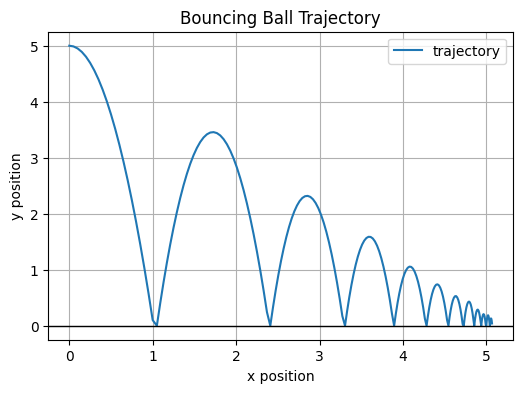

In [3]:
# Example trajectory

# initial position (0,5) (on y axis) and initial velocity (1,0) (to the right)
init_state = jnp.array([0.0, 5.0, 1.0, 0.0]) 
traj = simulate(init_state)
print(traj.shape)
plot_trajectory(traj)


# Start your solutions below this cell

In [4]:
import jax
import jax.numpy as jnp
from jax import jit, grad

pos_init = jnp.array([0.0, 1.0])
pos_target = jnp.array([8.0, 0.0])

optimized_v_init = jnp.array([1.0, 1.0]) 

def loss_function(v_init, p_init, p_target):
    init_state = jnp.concatenate([p_init, v_init])
    
    trajectory = simulate(init_state)
    
    final_pos = trajectory[-1, :2] 
    
    loss = jnp.sum((final_pos - p_target)**2)
    return loss

In [5]:
#def loss function
@jit
def jit_loss(v_init, p_init, p_target):
    return loss_function(v_init, p_init, p_target)

grad_func = grad(jit_loss, argnums=0) 

@jit
def gradient_descent_step(v_init, p_init, p_target, learning_rate):
    grad = grad_func(v_init, p_init, p_target)
    return v_init - learning_rate * grad

learning_rate = 0.001
num_epochs = 500 

for i in range(num_epochs):
    optimized_v_init = gradient_descent_step(optimized_v_init, pos_init, pos_target, learning_rate)
    
    if i % 100 == 0:
        current_loss = jit_loss(optimized_v_init, pos_init, pos_target)
        print(f"Iteration= {i} Loss = {current_loss:.6f}")
        
optimized_v_init = jax.block_until_ready(optimized_v_init)

Iteration= 0 Loss = 27.101357
Iteration= 100 Loss = 1.386264
Iteration= 200 Loss = 0.070910
Iteration= 300 Loss = 0.003626
Iteration= 400 Loss = 0.000186


optimized_v_init: [2.9441988 1.       ]
(201, 4)


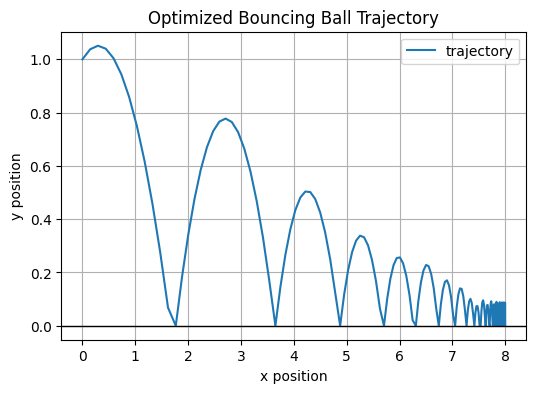

In [6]:
print(f"optimized_v_init: {optimized_v_init}")

new_init_state = jnp.concatenate([pos_init, optimized_v_init])
traj = simulate(new_init_state)
print(traj.shape)
plot_trajectory(traj, title="Optimized Bouncing Ball Trajectory")


In [9]:
final_pos = traj[-1, :2]
print(f"Final Landing Position: {final_pos}, it is very close to the target point.")

Final Landing Position: [7.9968705 0.       ], it is very close to the target point.
